In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

colors = sns.color_palette("tab10").as_hex()
colors = ["#402040"] + colors
palette = {
    "noir": colors[0],
    "noir-j2": colors[0],
    "noir-shared": colors[0],
    "noir-opt": colors[0],
    "omp": colors[4],
    "mpi": colors[4],
    "mpi-mmap": colors[4],
    "mpi-opemp": colors[4],
    "rayon": colors[3],
    "flink": colors[2],
    "timely": colors[5],
    "ideal": colors[8],
    "linear": colors[8],
}
linestyles = ["-", "--", ":", "-."]
sns.set_theme(context='paper', style='whitegrid', palette="tab10", font='Times New Roman', font_scale=1.5)

In [2]:
df = pd.read_csv("../../results/csv/nexmark-new.csv", dtype={"system": "string", "query": "string"})

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   system       135 non-null    string 
 1   parallelism  135 non-null    int64  
 2   query        135 non-null    string 
 3   time         135 non-null    float64
dtypes: float64(1), int64(1), string(2)
memory usage: 4.3 KB
None


In [3]:
su = df.groupby(["query", "system", "parallelism"])[["time"]].mean().reset_index()

print(su.head())

with open("../../results/csv/nexmark-human-readable.csv", "w") as f:
    su.to_csv(f)

  query  system  parallelism       time
0    q0   flink           32  21.359400
1    q0    noir           32   2.864363
2    q0  timely           32   4.525716
3    q1   flink           32  21.724600
4    q1    noir           32   2.876564


In [4]:
def hbarplot(data, path):
    ax = sns.barplot(data=data, x="time", y="query", orient="h",
                    hue="system", errorbar=("ci", 90), palette=palette, errwidth=0.5, capsize=0.1, errcolor=".5")
    ax.set_xlabel("execution time[s]")
    ax.set_ylabel("query")

    plt.axvline(x=10.0, color='.8', linestyle='--', linewidth="1.0")
    # plt.yticks(list(plt.yticks()[0]) + [10.0])

    for i in ax.containers:
        ax.bar_label(i, rotation=0, fmt="%.1f", padding=4)

    plt.savefig(path, bbox_inches="tight")
    plt.show()

def vbarplot(data, path):
    ax = sns.barplot(data=data, x="query", y="time",
                    hue="system", errorbar=("ci", 90), palette=palette, errwidth=0.5, capsize=0.1, errcolor=".5")

    ax.set_xlabel("query")
    ax.set_ylabel("execution time[s]")
    plt.axhline(y=10.0, color='.8', linestyle='--', linewidth="1.0")
    # plt.yticks(list(plt.yticks()[0]) + [10.0])

    for i in ax.containers:
        ax.bar_label(i, rotation=90, fmt="%.1f", padding=4)

    plt.savefig(path, bbox_inches="tight")
    plt.show()

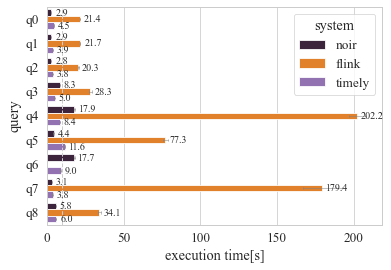

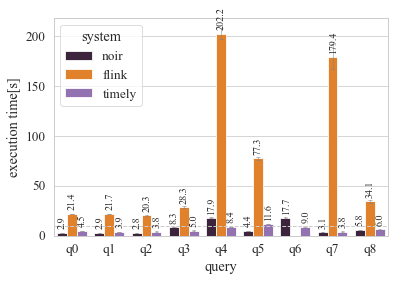

In [5]:
data = df
data = data[data["parallelism"] == 32]
# data = data[data["system"].isin(["noir", "timely", "flink"])]
data = data.sort_values(by=["query"])

hbarplot(data, "plots/nexmark-32-h.pdf")
vbarplot(data, "plots/nexmark-32-v.pdf")


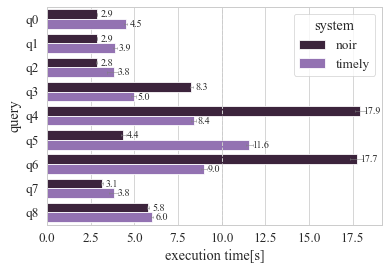

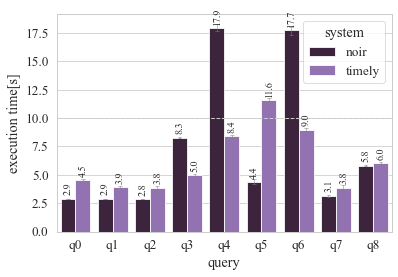

In [6]:
data = df
data = data[data["parallelism"] == 32]
data = data[data["system"].isin(["noir", "timely"])]
data = data.sort_values(by=["query"])

hbarplot(data, "plots/nexmark-32-h-noflink.pdf")
vbarplot(data, "plots/nexmark-32-v-noflink.pdf")


In [7]:
import statistics

def escape(l):
    return l.replace("_", "-")

def cell(times):
    if len(times) == 0:
        return " & \\(\\empty\\)"
    mean = statistics.mean(times)
    stdev = statistics.stdev(times)
    return f" & \\({mean:.3f}s_{{\\pm {stdev:.3f}}} \\)"

systems = ["noir", "flink"]
column_def = "| l |" + "".join([" c |" for _ in range(len(systems))])
table_rows = f"\t\t " + "".join([f" & \\textbf{{{sys}}}" for sys in systems]) + "\\\\ \\hline\\hline\n"
for q in range(9):
    row = "".join([
        f"\t\t\\textbf{{Q{q}}} " + "".join([cell(df[df["system"] == sys][df["query"] == f"q{q}"]["time"]) for sys in systems]) + "\\\\ \\hline\n"
    ])
    table_rows += row

# print(table_rows)


final = f"""\
\\begin{{table}}[h]
\t\\centering
\t\\scriptsize
\t\\begin{{tabular}}{{{column_def}}}\\hline
{table_rows}\
\t\\end{{tabular}}
\t\\caption{{Timing results for nexmark queries}}
\t\\label{{table:bench_nexmark}}
\\end{{table}}
"""

print(final)

# with open(f"tables/bench_{name}.tex", "w") as f:
#     f.write(final)

\begin{table}[h]
	\centering
	\scriptsize
	\begin{tabular}{| l | c | c |}\hline
		  & \textbf{noir} & \textbf{flink}\\ \hline\hline
		\textbf{Q0}  & \(2.864s_{\pm 0.006} \) & \(21.359s_{\pm 0.195} \)\\ \hline
		\textbf{Q1}  & \(2.877s_{\pm 0.010} \) & \(21.725s_{\pm 0.272} \)\\ \hline
		\textbf{Q2}  & \(2.837s_{\pm 0.011} \) & \(20.277s_{\pm 0.487} \)\\ \hline
		\textbf{Q3}  & \(8.274s_{\pm 0.101} \) & \(28.321s_{\pm 1.347} \)\\ \hline
		\textbf{Q4}  & \(17.935s_{\pm 0.466} \) & \(202.218s_{\pm 8.158} \)\\ \hline
		\textbf{Q5}  & \(4.359s_{\pm 0.280} \) & \(77.280s_{\pm 2.022} \)\\ \hline
		\textbf{Q6}  & \(17.743s_{\pm 0.532} \) & \(\empty\)\\ \hline
		\textbf{Q7}  & \(3.138s_{\pm 0.107} \) & \(179.397s_{\pm 19.708} \)\\ \hline
		\textbf{Q8}  & \(5.804s_{\pm 0.103} \) & \(34.103s_{\pm 1.670} \)\\ \hline
	\end{tabular}
	\caption{Timing results for nexmark queries}
	\label{table:bench_nexmark}
\end{table}



/tmp/ipykernel_4618/179295771.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f"\t\t\\textbf{{Q{q}}} " + "".join([cell(df[df["system"] == sys][df["query"] == f"q{q}"]["time"]) for sys in systems]) + "\\\\ \\hline\n"
